## Imports

In [61]:
!pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn

In [62]:
from datasets import load_dataset
import transformers as tf
import torch

import langchain as lg
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import langchain_community as lg_c
import ragatouille

import pandas as pd
import matplotlib.pyplot as plt
import gdown

import base64
from PIL import Image
import io

pd.set_option("display.max_colwidth", 50)

## Get Data

In [63]:
URL = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'

DATA_FILENAME = 'data.csv'

EMBEDDING_MODEL_NAME = 'DeepPavlov/rubert-base-cased'
READER_MODEL_NAME = 'Gusanidas/gus-2-7b-russ'
RERANKER_MODEL_NAME = 'colbert-ir/colbertv2.0'


gdown.download(URL, DATA_FILENAME, quiet=False)

data = pd.read_csv(DATA_FILENAME)

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=50e13d94-d612-4037-8d9e-b6eb428b8ecf
To: /kaggle/working/data.csv
100%|██████████| 672M/672M [00:02<00:00, 246MB/s]  


In [64]:
data.head()

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


<Axes: >

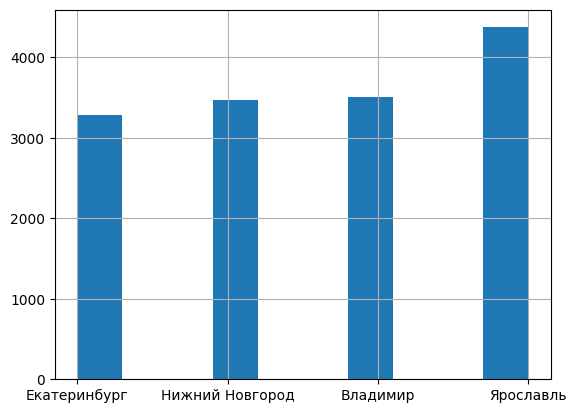

In [65]:
data['City'].hist()

In [66]:
data.sample(1)

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
2769,2995,Уральский государственный технический университет,Q1938341,Екатеринбург,60.654282,56.844051,бывшее название университета в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed view of a large white building with col...


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14634 entries, 0 to 14633
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   14634 non-null  int64  
 1   Name         14634 non-null  object 
 2   WikiData     12078 non-null  object 
 3   City         14634 non-null  object 
 4   Lon          14634 non-null  float64
 5   Lat          14634 non-null  float64
 6   description  12078 non-null  object 
 7   image        14634 non-null  object 
 8   en_txt       14634 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ MB


In [68]:
def get_image(img):
  return Image.open(io.BytesIO(base64.b64decode(img))).convert('RGB')

text


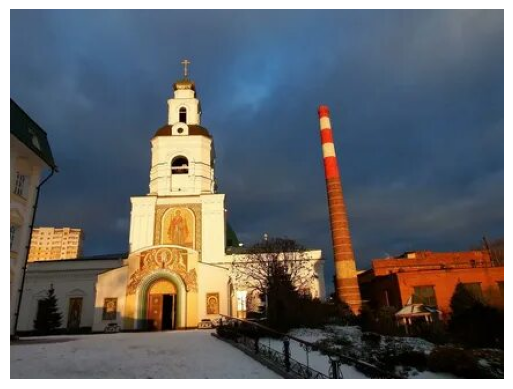

In [147]:
plt.imshow(get_image(data.sample(1)['image'].item()));
plt.axis(False);

In [71]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [100]:
RAW_KNOWLEDGE_BASE = []
unique_examples = set()
for _, doc in data.iterrows():
  if doc['Name'] not in unique_examples:
    RAW_KNOWLEDGE_BASE.append(Document(page_content=str(doc['Name']) + ' ' + str(doc['City']),
             metadata={'description': str(doc['description']), 'image': get_image(doc['image']), 'city': doc['City'], 'name': doc['Name']}))
    unique_examples.add(doc['Name'])

In [73]:
len(RAW_KNOWLEDGE_BASE)

387

In [101]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}
)
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    RAW_KNOWLEDGE_BASE, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [78]:
user_query = 'расскажи про памятники в Нижнем Новгороде'
answs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=10)

In [79]:
answs

[Document(id='97708f6f-ddfe-4566-acf9-50bb67debc8a', metadata={}, page_content='Дом Сироткина Нижний Новгород'),
 Document(id='f87dc68d-ba64-4465-866b-0b3219435fea', metadata={}, page_content='№19 Музей истории Екатеринбурга Екатеринбург'),
 Document(id='15e1a63b-7204-4214-a358-a5687dc2f52d', metadata={}, page_content='Администрация Нижнего Новгорода Нижний Новгород'),
 Document(id='9fbcefdf-05a3-4498-a0d9-3b86267748e9', metadata={}, page_content='Губернаторский сад Нижний Новгород'),
 Document(id='068aca56-3a79-4a79-b562-e36c5e275ab2', metadata={}, page_content='Дворец вице-губернатора Нижний Новгород'),
 Document(id='8105f7a6-2754-42df-9959-39f3e9cb57ea', metadata={}, page_content='Сормовский парк Нижний Новгород'),
 Document(id='a710b835-7aa6-4b5f-a26c-31c660c9b438', metadata={}, page_content='Дом архитектора Нижний Новгород'),
 Document(id='db53ebd1-4ab5-429b-94ca-9c4531387fb2', metadata={}, page_content='Памятник Ленину Нижний Новгород'),
 Document(id='7e0f5422-cb45-4dc8-a9dd-623f

In [80]:
bnb_cfg = tf.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = tf.AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_cfg)
tokenizer = tf.AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = tf.pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Device set to use cuda:0


In [81]:
READER_LLM('''ПРИМЕР: 1+2=3
              ВОПРОС: 5+4=''')

[{'generated_text': '9\n              ОТВЕТ:Да, так как 1+2=3 и 5+4=9.'}]

In [82]:
RERANKER_MODEL_NAME = 'colbert-ir/colbertv2.0'

In [83]:
RERANKER = ragatouille.RAGPretrainedModel.from_pretrained(RERANKER_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [153]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Используя информацию, содержащуюся в контексте,
дайте исчерпывающий ответ на вопрос.
Отвечайте только на заданный вопрос, ответ должен быть кратким и соответствовать сути вопроса.
Если ответ не может быть выведен из контекста, не отвечай"""
    },
    {
        "role": "user",
        "content": """Контест:
{context}
---
Здесь вопрос на который ты должен дать короткий используя контекст сверху

Вопрос: {question} 
Ответ:""",
    },
]

if not tokenizer.chat_template:
    tokenizer.chat_template = "{% for message in messages %}{{message['role']}}: {{message['content']}}\n{% endfor %}"
    
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False
)
print(RAG_PROMPT_TEMPLATE)

system: Используя информацию, содержащуюся в контексте,
дайте исчерпывающий ответ на вопрос.
Отвечайте только на заданный вопрос, ответ должен быть кратким и соответствовать сути вопроса.
Если ответ не может быть выведен из контекста, не отвечай
user: Контест:
{context}
---
Здесь вопрос на который ты должен дать короткий используя контекст сверху

Вопрос: {question} 
Ответ:



In [90]:
RAW_KNOWLEDGE_BASE[0]

Document(metadata={'description': 'спорткомплекс в Екатеринбурге', 'image': <PIL.Image.Image image mode=RGB size=480x252 at 0x7A3F198D6FB0>, 'city': 'Екатеринбург', 'name': 'Динамо'}, page_content='Динамо Екатеринбург')

In [176]:
def rag_answer(question: str,
               llm: tf.Pipeline = READER_LLM,
               knowledge_base: FAISS = KNOWLEDGE_VECTOR_DATABASE,
               reranker: ragatouille.RAGPretrainedModel = RERANKER,
               prompt: str = RAG_PROMPT_TEMPLATE,
               num_retrieved_docs: int = 15,
               num_docs_context: int = 5):
    retrieved_docs = knowledge_base.similarity_search(query=question, k=num_retrieved_docs)
    descr2doc = {doc.page_content: doc for doc in retrieved_docs}

    if reranker:
        reranked_docs = reranker.rerank(question, list(descr2doc.keys()), k=num_docs_context)
        final_docs = [descr2doc[doc['content']].metadata['description'] + doc['content'] for doc in reranked_docs]

    context = '\nДокументы:\n'
    context += ''.join([f'Документ №{str(i)}:::\n' + doc for i, doc in enumerate(final_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    answer = llm(final_prompt)[0]["generated_text"]
    img = descr2doc[reranked_docs[0]['content']].metadata['image']
    
    print(answer[:150])
    plt.imshow(img);
    plt.axis(False);
    
    return answer, img

100%|██████████| 1/1 [00:00<00:00, 26.62it/s]


Музеи в Нижнем Новгороде:

1. Автозаводский парк (Автозаводский парк культуры и отдыха)
2. Сормовский парк (Сормовский парк Нижний Новгород)
3. Памятн


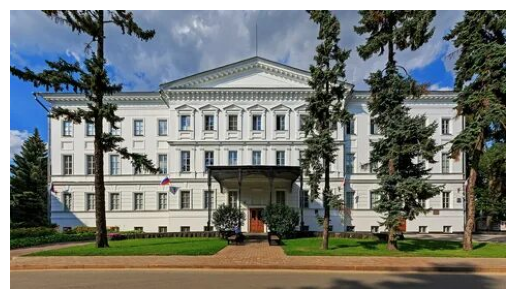

In [177]:
response = rag_answer('расскажи про музеи в Нижнем Новгороде')